In [1]:
!pip install tensorflow -t ./

     |████████████████████████████████| 454.3 MB 12 kB/s s eta 0:00:01     |████████████████████████████▌   | 405.0 MB 68.9 MB/s eta 0:00:01     |██████████████████████████████▌ | 432.5 MB 68.9 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 65 kB 5.6 MB/s  eta 0:00:01
     |████████████████████████████████| 462 kB 77.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 45.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 56.6 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 1.9 MB/s  eta 0:00:01
     |████████████████████████████████| 4.0 MB 50.3 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 59.8 MB/s eta 0:00:01
     |████████████████████████████████| 14.8 MB 44.5 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 50.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 45.5 MB/s eta 0:00:01
  Using cached cached_property-1.5.2-py2.

In [10]:
#import libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator 
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [2]:
all_miami = pd.read_csv('s3://partly-cloudy-ml-inputs/MIAMI_6_hour_flat.csv')
print(all_miami.head())

   LocalDateTimePeriod   Nx  Ny       Lat        Lon geoEncode   NAME  \
0  2020-06-03 00:00:00  242  58  29.27751 -78.877894     djpyt  MIAMI   
1  2021-03-04 12:00:00  242  58  29.27751 -78.877894     djpyt  MIAMI   
2  2021-01-20 18:00:00  242  58  29.27751 -78.877894     djpyt  MIAMI   
3  2020-12-15 18:00:00  242  58  29.27751 -78.877894     djpyt  MIAMI   
4  2021-04-23 00:00:00  242  58  29.27751 -78.877894     djpyt  MIAMI   

   pdISSRs200430  pdISSRs300370  pdMeanTemp200430  pdMeanTemp300370  \
0              1              0        238.740347        231.558500   
1              0              0        235.731056        227.435583   
2              0              0        235.499222        228.468417   
3              0              0        236.010181        226.869250   
4              0              0        236.284875        229.807958   

   pdMeanRH_ice200430  pdMeanRH_ice300370  
0           48.891528           70.813750  
1            7.273333            9.849583  
2 

In [4]:
#Creating a subset of the dataframe - Going to just look at ISSRs at FL 300 to FL 370
df2 = all_miami[['LocalDateTimePeriod', 'pdISSRs300370','Nx', 'Ny', 'Lat', 'Lon', 'pdMeanTemp300370', 'pdMeanRH_ice300370']]
df2 = df2[df2.LocalDateTimePeriod <= '2021-05-15 00:00:00']
df2 = df2[df2.LocalDateTimePeriod >= '2021-05-11 00:00:00']


df = all_miami[['LocalDateTimePeriod', 'pdISSRs300370','Nx', 'Ny', 'pdMeanTemp300370', 'pdMeanRH_ice300370']]
#Filter down to the time periodwe want to examine
#Going to use July 1st at midnight to July 5th 2020 at midnight
df = df[df.LocalDateTimePeriod <= '2021-05-14 00:00:00']
df = df[df.LocalDateTimePeriod >= '2021-05-11 00:00:00']

In [5]:
print(df.head())
print(df.info())

     LocalDateTimePeriod  pdISSRs300370   Nx  Ny  pdMeanTemp300370  \
34   2021-05-12 18:00:00              0  242  58        231.553208   
80   2021-05-13 12:00:00              1  242  58        231.546125   
255  2021-05-14 00:00:00              0  242  58        230.917542   
294  2021-05-13 18:00:00              1  242  58        231.243458   
361  2021-05-12 12:00:00              1  242  58        231.489083   

     pdMeanRH_ice300370  
34            88.930000  
80            88.775000  
255           66.565833  
294           83.837500  
361           68.444583  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10673 entries, 34 to 1193715
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   LocalDateTimePeriod  10673 non-null  object 
 1   pdISSRs300370        10673 non-null  int64  
 2   Nx                   10673 non-null  int64  
 3   Ny                   10673 non-null  int64  
 4   pdMeanT

In [6]:
#Convert variables into appropriate formats for analysis
#1. LocalDateTimePeriod -> Date object
df['LocalDateTimePeriod'] = pd.to_datetime(df['LocalDateTimePeriod'], infer_datetime_format=True)
#Check change has occured
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10673 entries, 34 to 1193715
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   LocalDateTimePeriod  10673 non-null  datetime64[ns]
 1   pdISSRs300370        10673 non-null  int64         
 2   Nx                   10673 non-null  int64         
 3   Ny                   10673 non-null  int64         
 4   pdMeanTemp300370     10673 non-null  float64       
 5   pdMeanRH_ice300370   10673 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3)
memory usage: 583.7 KB


In [7]:
#Create dataframe just for our inputs - Focusing on FL 300-370 For now
#Subsetting with pdISSRs300370, Nx, Ny
df_input = df[['pdISSRs300370', 'Nx', 'Ny', 'pdMeanTemp300370', 'pdMeanRH_ice300370']]
print(df_input)

         pdISSRs300370   Nx  Ny  pdMeanTemp300370  pdMeanRH_ice300370
34                   0  242  58        231.553208           88.930000
80                   1  242  58        231.546125           88.775000
255                  0  242  58        230.917542           66.565833
294                  1  242  58        231.243458           83.837500
361                  1  242  58        231.489083           68.444583
...                ...  ...  ..               ...                 ...
1193575              0  241  33        231.370542           37.496667
1193599              0  241  33        232.607875           80.333333
1193609              0  241  33        231.420792           80.698333
1193674              0  241  33        231.877500           36.448333
1193715              0  241  33        231.472083           72.250833

[10673 rows x 5 columns]


In [8]:
#Even though last 2 columns are float-64 want all input variables to be.
df_input= df_input.astype('float64')
df_input.describe()

,pdISSRs300370,Nx,Ny,pdMeanTemp300370,pdMeanRH_ice300370
count,10673.000000,10673.000000,10673.000000,10673.000000,10673.000000
mean,0.144477,235.537150,44.494519,231.685506,73.931839
std,0.458880,9.398792,9.065840,0.966689,12.845356
min,0.000000,213.000000,28.000000,229.396583,23.047500
25%,0.000000,228.000000,37.000000,231.045792,67.630833
50%,0.000000,236.000000,45.000000,231.683125,76.891250
75%,0.000000,243.000000,51.000000,232.473208,83.050417
max,5.000000,255.000000,63.000000,233.946542,96.980417


In [11]:
#Scale inputs - Sigmmoid and Tanh functions
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
#scaled data is a 2D array all values are between 0-1.
data_scaled

array([[-0.31486082,  0.68765785,  1.48978069, -0.13686238,  1.16764875],
       [ 1.86445794,  0.68765785,  1.48978069, -0.14419013,  1.15558157],
       [-0.31486082,  0.68765785,  1.48978069, -0.79446393, -0.57346412],
       ...,
       [-0.31486082,  0.58125622, -1.26795277, -0.27384833,  0.5267905 ],
       [-0.31486082,  0.58125622, -1.26795277,  0.19861959, -2.91819566],
       [-0.31486082,  0.58125622, -1.26795277, -0.22078675, -0.13087098]])

In [12]:
#store as feature variable
features = data_scaled
#our output/target variable is also pdISSRs300370 so will index for first part of array and store as target.
target = data_scaled[:,0]
print(target)

[-0.31486082  1.86445794 -0.31486082 ... -0.31486082 -0.31486082
 -0.31486082]


In [13]:
#Using timseriesgenerator to convert 2d to 3d arrays but also using a sample of data for this:
#Will update batch size to be larger later, length is the period of time in which we want to be able to predict
#Since data is in 6-hour increments, lets set length = 1 which means predicting 6 hours ahead.
#First row printed reflects our input values and the 2nd array printed is the output when predicting 6 hours ahead
#This prediction gives us an ISSR count of 0
TimeseriesGenerator(features, target, length = 1, sampling_rate = 1, batch_size =1)[0]

(array([[[-0.31486082,  0.68765785,  1.48978069, -0.13686238,
           1.16764875]]]),
 array([1.86445794]))

In [14]:
#Split our data into training and testing data - 70% training & 30% testing. Also don't want to shuffle, keep
#order in tact
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size = 0.30,
random_state = 123, shuffle = False)

print(x_train.shape)
print(x_test.shape)

(7471, 5)
(3202, 5)


In [15]:
#Actual Timseries generator
#Data for every 6 hours, 24 hours we have 4 data points of 6 hours
#In day of 6 hour intervals we have 4 Data Points, we are taking 3 days of data so 4 x 3 = 12 for window length
#5 features now.

#Each day we have 4 data points, we have 3 days of training data and using the 3 days of data going to print next
#observation. Batch size 32 - Each training instance, passing 32 batch size of data, with 5 features (input size)
win_length = 12
batch_size = 32
num_features = 5

#train generator - Passes the 70% of data, length is 12 for those 3 days of data and predict next instance.
train_generator = TimeseriesGenerator(x_train, y_train, length = win_length, sampling_rate =1,batch_size = batch_size)
#test generator based on 30% of data
test_generator = TimeseriesGenerator(x_test, y_test, length = win_length, sampling_rate=1, batch_size = batch_size)

#Will contain 32 observations bc of the batch size variable each 12 having 5 observations bc 5 features
train_generator[0]

(array([[[-0.31486082,  0.68765785,  1.48978069, -0.13686238,
           1.16764875],
         [ 1.86445794,  0.68765785,  1.48978069, -0.14419013,
           1.15558157],
         [-0.31486082,  0.68765785,  1.48978069, -0.79446393,
          -0.57346412],
         ...,
         [-0.31486082,  0.68765785,  1.48978069, -0.22401958,
           0.79398778],
         [-0.31486082,  0.68765785,  1.48978069, -1.64056127,
          -1.407819  ],
         [-0.31486082,  0.68765785,  1.48978069, -1.80121157,
          -1.37992175]],
 
        [[ 1.86445794,  0.68765785,  1.48978069, -0.14419013,
           1.15558157],
         [-0.31486082,  0.68765785,  1.48978069, -0.79446393,
          -0.57346412],
         [ 1.86445794,  0.68765785,  1.48978069, -0.45730089,
           0.7711834 ],
         ...,
         [-0.31486082,  0.68765785,  1.48978069, -1.64056127,
          -1.407819  ],
         [-0.31486082,  0.68765785,  1.48978069, -1.80121157,
          -1.37992175],
         [-0.31486082, 

In [16]:
#Define our model architecture
model = Sequential()

#4(nm+n^2) where n - length of input vector in each time step (5) m - length of output vector (1)
#4(5*1 + 5^2) = 4(5 + 25) =4(30) = 120.

#telling LSTM layer number of units is 120, input shape is 12 instances with 5 features
#need hidden state for each observation
model.add(LSTM(120, activation='relu', input_shape = (win_length, num_features), return_sequences=False))
#model.add(LSTM(20, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mse', 'accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120)               60480     
_________________________________________________________________
dropout (Dropout)            (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 60,601
Trainable params: 60,601
Non-trainable params: 0
_________________________________________________________________


In [17]:
#early stopping is telling model to monitor the loss in the valiation dataset, will decrease for validation accuracy
#training will stop when chosen performance measure stops imporving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 2, mode='min')

In [18]:
#defining model

model.compile(optimizer='adam', loss='mse', metrics = ['mse', 'accuracy'])
#passing training df. don't shuffle the data, for now validation and test will be the same - change in future.
history = model.fit_generator(train_generator, epochs = 5, validation_data = test_generator, shuffle = False
                             ,callbacks=[early_stopping])

/home/ec2-user/SageMaker/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
234/234 [==============================] - 28s 12ms/step - loss: 1.0606 - mse: 1.0606 - accuracy: 0.0000e+00 - val_loss: 0.9414 - val_mse: 0.9414 - val_accuracy: 0.0000e+00
Epoch 2/5
234/234 [==============================] - 2s 9ms/step - loss: 1.0312 - mse: 1.0312 - accuracy: 0.0000e+00 - val_loss: 0.9436 - val_mse: 0.9436 - val_accuracy: 0.0000e+00
Epoch 3/5
234/234 [==============================] - 2s 9ms/step - loss: 1.0224 - mse: 1.0224 - accuracy: 0.0000e+00 - val_loss: 0.9487 - val_mse: 0.9487 - val_accuracy: 0.0000e+00


In [1]:
#Loss for each feature
print(history.history['loss'])
#Accuracy for each feature
print(history.history['accuracy'])
#Validation loss for each feature
print(history.history['val_loss'])
#Validation accuracy for each feature
print(history.history['val_accuracy'])

#plotting loss of training data vs. validation data loss for each epoch.
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

NameError: name 'history' is not defined

In [20]:
model.evaluate_generator(test_generator, verbose = 0)

/home/ec2-user/SageMaker/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.9487083554267883, 0.9487083554267883, 0.0]

In [21]:
#training_predictions = model.predict_generator(train_generator)
#print(training_predictions)

#using test generator data for the predictive model
predictions = model.predict_generator(test_generator)
print(predictions.shape[0])

print(predictions)

/home/ec2-user/SageMaker/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


3190
[[ 0.3999713 ]
 [ 0.4154691 ]
 [ 0.41558158]
 ...
 [-0.1673248 ]
 [-0.19456431]
 [-0.2008    ]]


In [22]:
y_test

array([-0.31486082, -0.31486082, -0.31486082, ..., -0.31486082,
       -0.31486082, -0.31486082])

In [23]:
x_test

array([[-0.31486082, -1.44037493, -0.93702476,  1.14838314,  0.25041308],
       [-0.31486082, -1.44037493, -0.93702476,  0.87333361,  0.33199632],
       [-0.31486082, -1.44037493, -0.93702476,  0.05322827,  0.85795682],
       ...,
       [-0.31486082,  0.58125622, -1.26795277, -0.27384833,  0.5267905 ],
       [-0.31486082,  0.58125622, -1.26795277,  0.19861959, -2.91819566],
       [-0.31486082,  0.58125622, -1.26795277, -0.22078675, -0.13087098]])

In [24]:
x_test[:,1:][win_length:]

array([[-2.39798969,  0.16606863,  0.87066114,  1.31738563],
       [-2.39798969,  0.16606863,  0.2868113 ,  1.59999127],
       [-2.39798969,  0.16606863, -1.52456718,  0.01610861],
       ...,
       [ 0.58125622, -1.26795277, -0.27384833,  0.5267905 ],
       [ 0.58125622, -1.26795277,  0.19861959, -2.91819566],
       [ 0.58125622, -1.26795277, -0.22078675, -0.13087098]])

In [25]:
#df_train_pred = pd.concat([pd.DataFrame(training_predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
df_pred=pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])], axis=1)
print(df_pred)

             0         0         1         2         3
0     0.399971 -2.397990  0.166069  0.870661  1.317386
1     0.415469 -2.397990  0.166069  0.286811  1.599991
2     0.415582 -2.397990  0.166069 -1.524567  0.016109
3     0.266448 -2.397990  0.166069 -1.143955 -0.619300
4     0.224805 -2.397990  0.166069  1.103468  0.450592
...        ...       ...       ...       ...       ...
3185 -0.184432  0.581256 -1.267953 -0.325832 -2.836580
3186 -0.226274  0.581256 -1.267953  0.954198  0.498374
3187 -0.167325  0.581256 -1.267953 -0.273848  0.526790
3188 -0.194564  0.581256 -1.267953  0.198620 -2.918196
3189 -0.200800  0.581256 -1.267953 -0.220787 -0.130871

[3190 rows x 5 columns]


In [26]:
#rev_training = scaler.inverse_transform(df_train_pred)
#print(rev_training)

#Inversing the scaler
rev_trans = scaler.inverse_transform(df_pred)
print(rev_trans)

[[3.28007145e-01 2.13000000e+02 4.60000000e+01 2.32527125e+02
  9.08533333e+01]
 [3.35118452e-01 2.13000000e+02 4.60000000e+01 2.31962750e+02
  9.44833333e+01]
 [3.35170061e-01 2.13000000e+02 4.60000000e+01 2.30211792e+02
  7.41387500e+01]
 ...
 [6.76982305e-02 2.41000000e+02 3.30000000e+01 2.31420792e+02
  8.06983333e+01]
 [5.51991336e-02 2.41000000e+02 3.30000000e+01 2.31877500e+02
  3.64483333e+01]
 [5.23378317e-02 2.41000000e+02 3.30000000e+01 2.31472083e+02
  7.22508333e+01]]


In [27]:
#df_training_results = df_input[training_predictions.shape[0]*-1:]
#print(df_training_results)


df_final = df_input[predictions.shape[0]*-1:]
print(df_final)

         pdISSRs300370     Nx    Ny  pdMeanTemp300370  pdMeanRH_ice300370
836755             0.0  213.0  46.0        232.527125           90.853333
836855             1.0  213.0  46.0        231.962750           94.483333
837085             0.0  213.0  46.0        230.211792           74.138750
837105             0.0  213.0  46.0        230.579708           65.977083
837411             0.0  213.0  46.0        232.752167           79.719583
...                ...    ...   ...               ...                 ...
1193575            0.0  241.0  33.0        231.370542           37.496667
1193599            0.0  241.0  33.0        232.607875           80.333333
1193609            0.0  241.0  33.0        231.420792           80.698333
1193674            0.0  241.0  33.0        231.877500           36.448333
1193715            0.0  241.0  33.0        231.472083           72.250833

[3190 rows x 5 columns]


In [28]:
#Ensure count is correct.
df_final.count()

pdISSRs300370         3190
Nx                    3190
Ny                    3190
pdMeanTemp300370      3190
pdMeanRH_ice300370    3190
dtype: int64

In [29]:
#df_training_results['ISSR_200430_Pred'] = rev_training[:,0]
#print(df_training_results)
#printing entire df with predicted values attached
df_final['ISSR_300370_Pred'] = rev_trans[:,0]
print(df_final)

         pdISSRs300370     Nx    Ny  pdMeanTemp300370  pdMeanRH_ice300370  \
836755             0.0  213.0  46.0        232.527125           90.853333   
836855             1.0  213.0  46.0        231.962750           94.483333   
837085             0.0  213.0  46.0        230.211792           74.138750   
837105             0.0  213.0  46.0        230.579708           65.977083   
837411             0.0  213.0  46.0        232.752167           79.719583   
...                ...    ...   ...               ...                 ...   
1193575            0.0  241.0  33.0        231.370542           37.496667   
1193599            0.0  241.0  33.0        232.607875           80.333333   
1193609            0.0  241.0  33.0        231.420792           80.698333   
1193674            0.0  241.0  33.0        231.877500           36.448333   
1193715            0.0  241.0  33.0        231.472083           72.250833   

         ISSR_300370_Pred  
836755           0.328007  
836855           0.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<AxesSubplot:>

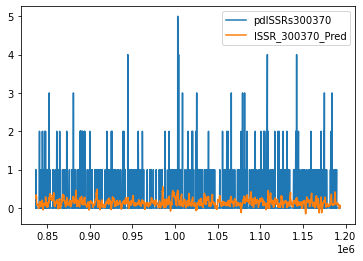

In [30]:
#df_training_results[['pdISSRs300370', 'ISSR_300370_Pred']].plot()

#Plot comparison of actual ISSR count for FL 300-370(blue) and Predicted ISSR count (orange)
df_final[['pdISSRs300370', 'ISSR_300370_Pred']].plot()

In [31]:
round(df_final['ISSR_300370_Pred'],0)

836755     0.0
836855     0.0
837085     0.0
837105     0.0
837411     0.0
          ... 
1193575    0.0
1193599    0.0
1193609    0.0
1193674    0.0
1193715    0.0
Name: ISSR_300370_Pred, Length: 3190, dtype: float64

In [32]:
#df_training_results['ISSR_300370_Pred'].describe()
#Distribution of predicted values
df_final['ISSR_300370_Pred'].describe()

count    3190.000000
mean        0.137554
std         0.091639
min        -0.155019
25%         0.076208
50%         0.126511
75%         0.187162
max         0.552870
Name: ISSR_300370_Pred, dtype: float64

In [33]:
#Distribution of predicted values
df_final['pdISSRs300370'].describe()

count    3190.000000
mean        0.143887
std         0.445512
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.000000
Name: pdISSRs300370, dtype: float64

In [34]:
print(df_final)

         pdISSRs300370     Nx    Ny  pdMeanTemp300370  pdMeanRH_ice300370  \
836755             0.0  213.0  46.0        232.527125           90.853333   
836855             1.0  213.0  46.0        231.962750           94.483333   
837085             0.0  213.0  46.0        230.211792           74.138750   
837105             0.0  213.0  46.0        230.579708           65.977083   
837411             0.0  213.0  46.0        232.752167           79.719583   
...                ...    ...   ...               ...                 ...   
1193575            0.0  241.0  33.0        231.370542           37.496667   
1193599            0.0  241.0  33.0        232.607875           80.333333   
1193609            0.0  241.0  33.0        231.420792           80.698333   
1193674            0.0  241.0  33.0        231.877500           36.448333   
1193715            0.0  241.0  33.0        231.472083           72.250833   

         ISSR_300370_Pred  
836755           0.328007  
836855           0.

In [35]:
#last 30% of original dataframe - want to join the timestamp to predicted results
#so look at last 3190

df2 = df2.iloc[-3190:]
print(df2)

         LocalDateTimePeriod  pdISSRs300370   Nx  Ny        Lat        Lon  \
920834   2021-05-11 12:00:00              0  217  48  27.913740 -84.250476   
921044   2021-05-14 06:00:00              0  217  48  27.913740 -84.250476   
921229   2021-05-11 06:00:00              0  217  48  27.913740 -84.250476   
921330   2021-05-14 00:00:00              1  217  48  27.913740 -84.250476   
921369   2021-05-14 12:00:00              0  217  48  27.913740 -84.250476   
...                      ...            ...  ...  ..        ...        ...   
1193593  2021-05-14 06:00:00              0  241  33  24.765398 -79.674515   
1193599  2021-05-13 00:00:00              0  241  33  24.765398 -79.674515   
1193609  2021-05-12 06:00:00              0  241  33  24.765398 -79.674515   
1193674  2021-05-11 12:00:00              0  241  33  24.765398 -79.674515   
1193715  2021-05-12 00:00:00              0  241  33  24.765398 -79.674515   

         pdMeanTemp300370  pdMeanRH_ice300370  
920834         

In [36]:
#concat original date-time-stamp to results
df_final['datetime'] = df2['LocalDateTimePeriod']
df_final['Lat'] = df2['Lat']
df_final['Lon'] = df2['Lon']
print(df_final)

         pdISSRs300370     Nx    Ny  pdMeanTemp300370  pdMeanRH_ice300370  \
836755             0.0  213.0  46.0        232.527125           90.853333   
836855             1.0  213.0  46.0        231.962750           94.483333   
837085             0.0  213.0  46.0        230.211792           74.138750   
837105             0.0  213.0  46.0        230.579708           65.977083   
837411             0.0  213.0  46.0        232.752167           79.719583   
...                ...    ...   ...               ...                 ...   
1193575            0.0  241.0  33.0        231.370542           37.496667   
1193599            0.0  241.0  33.0        232.607875           80.333333   
1193609            0.0  241.0  33.0        231.420792           80.698333   
1193674            0.0  241.0  33.0        231.877500           36.448333   
1193715            0.0  241.0  33.0        231.472083           72.250833   

         ISSR_300370_Pred             datetime        Lat        Lon  
8367

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [37]:
df_final.info()

#date column not datetime type
df_final['datetime'] = pd.to_datetime(df_final['datetime']) 
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190 entries, 836755 to 1193715
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pdISSRs300370       3190 non-null   float64
 1   Nx                  3190 non-null   float64
 2   Ny                  3190 non-null   float64
 3   pdMeanTemp300370    3190 non-null   float64
 4   pdMeanRH_ice300370  3190 non-null   float64
 5   ISSR_300370_Pred    3190 non-null   float64
 6   datetime            2438 non-null   object 
 7   Lat                 2438 non-null   float64
 8   Lon                 2438 non-null   float64
dtypes: float64(8), object(1)
memory usage: 249.2+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3190 entries, 836755 to 1193715
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   pdISSRs300370       3190 non-null   float64       
 1   Nx    

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [38]:
df_final['datetime'].value_counts()

2021-05-13 12:00:00    188
2021-05-12 06:00:00    188
2021-05-13 18:00:00    188
2021-05-12 12:00:00    188
2021-05-11 06:00:00    188
2021-05-14 00:00:00    188
2021-05-11 12:00:00    188
2021-05-11 00:00:00    187
2021-05-13 00:00:00    187
2021-05-11 18:00:00    187
2021-05-13 06:00:00    187
2021-05-12 00:00:00    187
2021-05-12 18:00:00    187
Name: datetime, dtype: int64

In [40]:
#Create a new dataframe of just the datetime, original ISSR counts, and predicted ISSR counts
#https://stackoverflow.com/questions/34682828/extracting-specific-selected-columns-to-new-dataframe-as-a-copy
df_ISSR_counts = df_final[['datetime', 'pdISSRs300370', 'ISSR_300370_Pred']].copy()
print(df_ISSR_counts)

#group the dataframe by date and sum of the ISSR counts
df_ISSR_counts.resample('D', on='datetime').sum()


#df_ISSR_counts.resample('D', on='datetime').mean()

                   datetime  pdISSRs300370  ISSR_300370_Pred
836755                  NaT            0.0          0.328007
836855                  NaT            1.0          0.335118
837085                  NaT            0.0          0.335170
837105                  NaT            0.0          0.266739
837411                  NaT            0.0          0.247631
...                     ...            ...               ...
1193575 2021-05-11 00:00:00            0.0          0.059849
1193599 2021-05-13 00:00:00            0.0          0.040649
1193609 2021-05-12 06:00:00            0.0          0.067698
1193674 2021-05-11 12:00:00            0.0          0.055199
1193715 2021-05-12 00:00:00            0.0          0.052338

[3190 rows x 3 columns]


,pdISSRs300370,ISSR_300370_Pred
datetime,,
2021-05-11,83.0,102.267576
2021-05-12,164.0,103.717518
2021-05-13,97.0,103.684235
2021-05-14,8.0,24.882701


In [49]:
#Actual vs. Predicted at each 6 hour interval
df_ISSR_counts.resample('6H', on='datetime').sum()

,pdISSRs300370,ISSR_300370_Pred
datetime,,
2021-05-11 00:00:00,8.0,24.714874
2021-05-11 06:00:00,14.0,25.228778
2021-05-11 12:00:00,33.0,25.903136
2021-05-11 18:00:00,28.0,26.420788
2021-05-12 00:00:00,41.0,26.799469
2021-05-12 06:00:00,49.0,25.317237
2021-05-12 12:00:00,51.0,25.465946
2021-05-12 18:00:00,23.0,26.134866
2021-05-13 00:00:00,51.0,26.369150


In [42]:
df_6_ISSR_count = df_ISSR_counts.resample('6H', on='datetime').sum()

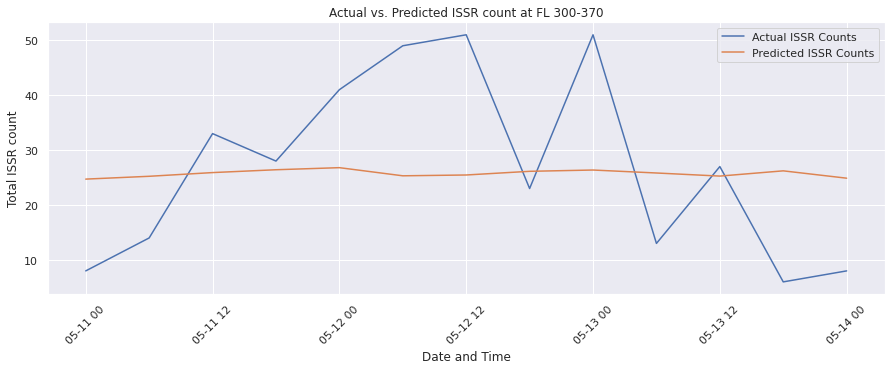

In [50]:
sns.lineplot(x = 'datetime', y = 'pdISSRs300370', data = df_6_ISSR_count,)
sns.lineplot(x = 'datetime', y = 'ISSR_300370_Pred', data = df_6_ISSR_count)
plt.title('Actual vs. Predicted ISSR count at FL 300-370')
plt.xlabel('Date and Time')
plt.ylabel ('Total ISSR count')
plt.xticks(rotation = 45)
sns.set(rc={'figure.figsize':(15,5)})
plt.legend(labels=["Actual ISSR Counts","Predicted ISSR Counts"])
plt.show()